In [13]:
"""
RELEVANT LINKS:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
"""
import pandas as pd
import numpy as np
from concat_stations import concat_files
import data_prep
from rf_optimize import evaluate
from scipy import stats

import json
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV   #Perforing grid search

In [14]:
# Load data and concatenate stations
# full_data = concat_files()
path=os.getcwd()
data_filename = os.path.join(path, "RLM_full_data.csv")
full_data = pd.read_csv(data_filename, index_col=None, header=0)

# Replcae NaNs with medians
full_data = data_prep.nan_to_median(full_data)

In [15]:
# We reomve the unimportant features
new_full_data = full_data.drop(columns=['weekday','windMeanSpeed.m.s', 'windDirection.grades', 'windMaxSpeed.m.s','precipitation.l.m2', 'year', 'month'])
df_features = [x for x in full_data.columns if x not in ['bikes','weekday','windMeanSpeed.m.s', 'windDirection.grades', 'windMaxSpeed.m.s','precipitation.l.m2', 'year', 'month']]

# Remove the outliers (omitted for now)
# full_data.apply(pd.to_numeric, errors='coerce')
# new_full_data = data_prep.remove_outliers(full_data)

# Make target and feature arrays
y = np.array(new_full_data['bikes']) # array for target variable
X = new_full_data[df_features] # Features (discluding bikes)
X = np.array(X) # Turn into numpy array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state= 42)

In [16]:
# Potential paramters - final uncommented 'params' are the tuned paramters which deliver best performance so far
# params = {'n_estimators' : 140, 'min_samples_split' : 2, 'min_samples_leaf' : 1,  'max_features' : 'sqrt', 'max_depth' : None, 'learning_rate' : 0.01}

# params = {"max_depth":7, "min_samples_leaf":30, "min_samples_split":600, "n_estimators" : 140, "random_state" :10, "subsample":0.6}#, "max_features" : 8}

# params = {"max_depth":7, "min_samples_leaf":30, "min_samples_split":600, "n_estimators" : 3000, "random_state" :10, "subsample":0.6, "max_features" : "sqrt", "learning_rate" : 0.005}

# params = {"max_depth":7, "min_samples_leaf":30, "min_samples_split":600, "n_estimators" : 1400, "random_state" :10, "subsample":0.6, "max_features" : "sqrt", "learning_rate" : 0.01}

params = {"max_depth":7, "min_samples_leaf":30, "min_samples_split":600, "n_estimators" : 1400, "random_state" :10, "subsample":0.75, "max_features" : 7, "learning_rate" : 0.01}

In [7]:
# Instantiate the model
reg = ensemble.GradientBoostingRegressor(**params)

# Fit the model (tuned model LRSS- has subsample split 0.7, 1400 and lr of 1400)
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mae = metrics.mean_absolute_error(y_test, reg.predict(X_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

The mean absolute error (MAE) on test set: 2.2108


In [19]:
# Save model to local disk
import joblib
joblib.dump(reg, "tuned_GB_model_RLM.joblib")

['tuned_GB_model_RLM.joblib']

In [17]:
# Below is if you want to train and test the model with cross validation

def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):

    """
    Trains the model with cross validations and returns the meaan negative absolute error (b/c mae isn't an option - the same jsut remove sign) over all cross validation subsamples. Also prints graph showing feature importances. 
    """
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['bikes'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    # dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['bikes'], cv=cv_folds, scoring= 'neg_mean_absolute_error')
    
    #Print model report:
    mae = metrics.mean_absolute_error(dtrain['bikes'].values, dtrain_predictions)
    print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
    
    print(cv_score)
    if performCV:
        print("CV Score : Mean - {} | Std - {} | Min - {} | Max - {}".format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


The mean absolute error (MAE) on test set: 2.1323
[-2.54219906 -2.94635114 -2.74916801 -2.21058332 -1.85961881]
CV Score : Mean - -2.4615840662715316 | Std - 0.38718624990239914 | Min - -2.946351139279634 | Max - -1.8596188066380057


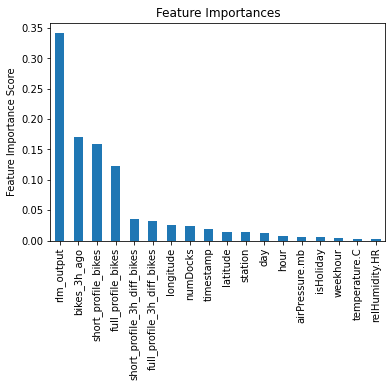

In [18]:
# Fit and test the model using cross val and the tuned paramters.
predictors = [x for x in new_full_data.columns if x not in ['bikes']]
gbm_tuned = ensemble.GradientBoostingRegressor(learning_rate=0.01, n_estimators=1400,max_depth=7, min_samples_split=600,min_samples_leaf=30, subsample=0.6, random_state=10, max_features='sqrt')
modelfit(gbm_tuned, new_full_data, predictors)

In [ ]:
# IGNORE BELOW

In [25]:

import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn import metrics

from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

The mean absolute error (MAE) on test set: 2.4175
[-2.59924515 -2.98628814 -2.81923184 -2.28900871 -1.98699828]
CV Score : Mean - -2.5361544241859018 | Std - 0.3603851016321123 | Min - -2.9862881420815754 | Max - -1.9869982764305103


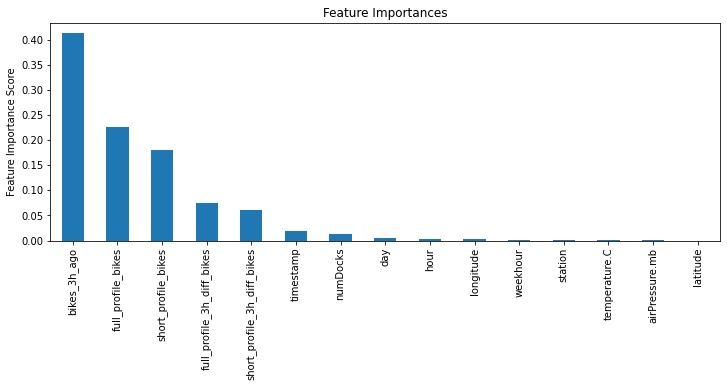

In [27]:
# Run a baseline model
#Choose all predictors except target & IDcols
predictors = [x for x in new_full_data.columns if x not in ['bikes']]
gbm0 = ensemble.GradientBoostingRegressor(random_state=10)

# Note that this returns the negative MAE for the cross validation results
modelfit(gbm0, new_full_data, predictors) #Fit the model

params = {"max_depth":7, "min_samples_leaf":30, "min_samples_split":600, "n_estimators" : 1400, "random_state" :10, "subsample":0.6, "max_features" : "sqrt", "learning_rate" : 0.01}

In [10]:

# IGNORE FOR NOW 
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

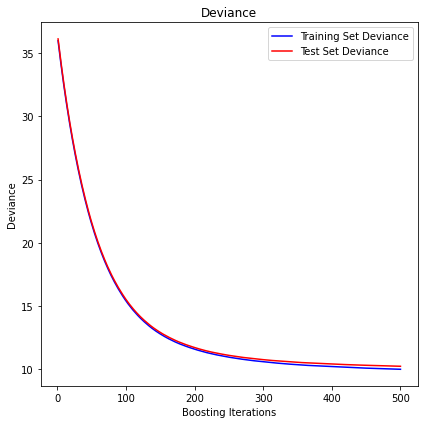

In [11]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()